## Risk
#### 19.04.2019

In [1]:
# connection necessary packeges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco

## Helpfull function

In [2]:
# profitability and volatility of the portfolio
def port(df, n_assets, N, n_days, cov, r_f):
    df['Mu'] = 0
    df['Volatility'] = 0
    for i in range(N + 1):
        # weights
        d = np.array(df.iloc[i, :n_assets])
        # Portfolio profitability
        df.iloc[i, (n_assets + 1)] = port_mean(d, means, n_days=250)
        # The volatility of the portfolio
        df.iloc[i, (n_assets + 2)] = port_vol(d, cov, n_days=250)
    df['Sharp_ratio'] = (df['Mu'] - r_f) / df['Volatility']


# profitability of the portfolio
def port_mean(d, means, n_days=250):
    d = np.array(d)
    return np.sum(means * d) * n_days


# volatility of the portfolio
def port_vol(d, cov, n_days=250):
    d = np.array(d)
    return np.sqrt(np.dot(d.T, np.dot(cov * n_days, d)))


# Variation of the portfolio
def port_varianced(d, cov, n_days=250):
    d = np.array(d)
    return np.dot(d.T, np.dot(cov * n_days, d))


# Sharpe ratio 
def Sharpe_ratio(weights, cov, means, r_f, n_days=250):
    weights = np.array(weights)
    mean = np.sum(means * weights) * n_days
    vol = np.sqrt(np.dot(weights.T, np.dot(cov * n_days, weights)))
    return -((mean-r_f)/vol)


# generator weights of the assets in the portfolio
def port_weight(n_assets):
    weights = []
    for i in range(n_assets):
        mu = moex_weights[i]
        std = 0.2
        d = round(random.normalvariate(mu, std), 4)
        weights.append(d)
    if sum(weights) != 1:
        diff = 1- sum(weights)
        diff /= n_assets
        weights = [i + diff for i in weights]
        return weights


# Generating portfolio 
def portfolio(df, n_assets, N, n_days, cov, r_f):
    for i in range(1, N + 1):
        weight = np.array(port_weight(n_assets))
        df.loc[i] = weight
    df['Sum'] = df.sum(axis=1)
    port(df, n_assets, N, n_days, cov, r_f)

In [46]:
ret = np.linspace(0,.6,1000)
risk_tol = range(1, 11)
work = {'Return': list(ret)}
for tol in risk_tol:
    work[tol] = [np.sqrt(2 * i / tol) for i in ret]
work = pd.DataFrame(work)
work.head()

,Return,1,2,3,4,5,6,7,8,9,10
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000601,0.034658,0.024507,0.020010,0.017329,0.015500,0.014149,0.013100,0.012254,0.011553,0.010960
2,0.001201,0.049014,0.034658,0.028298,0.024507,0.021920,0.020010,0.018526,0.017329,0.016338,0.015500
3,0.001802,0.060030,0.042448,0.034658,0.030015,0.026846,0.024507,0.022689,0.021224,0.020010,0.018983
4,0.002402,0.069317,0.049014,0.040020,0.034658,0.030999,0.028298,0.026199,0.024507,0.023106,0.021920


## Utilyti curves

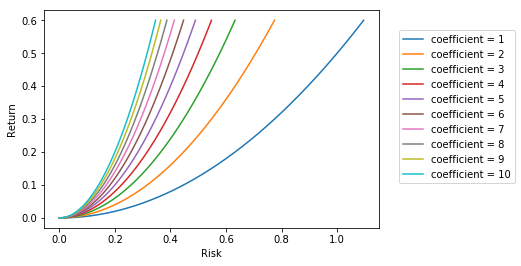

In [56]:
for i in list(work.columns)[1:]:
    _=plt.plot(work[i], work['Return'], label = 'coefficient = ' + str(i))
_=plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad = 2)
ax = plt.gca()
_=ax.set_xlabel('Risk', fontsize=10)
_=ax.set_ylabel('Return', fontsize=10)

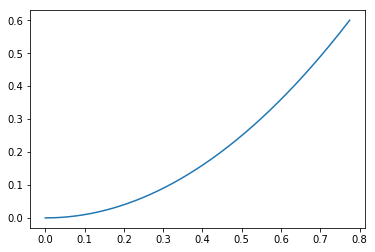

In [51]:
temp = list(work[2])
work_a = pd.DataFrame({'Risk': temp, 'No': [i**2 for i in temp]})


In [44]:
z = list(np.linspace(0,.2, 4))
for j in range(len(z)):
    i = z.pop(0)
    i = round(i, 2)
    z.append(i)

In [53]:
for i in z:
    work_a[i] = [j + i for j in work_a['No']]

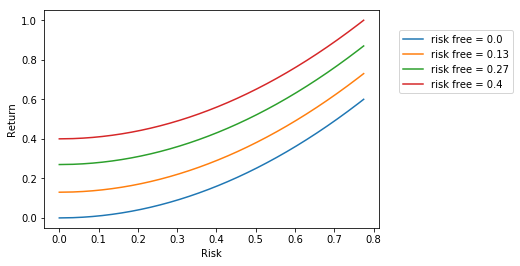

In [55]:
for i in z:
    _=plt.plot(work_a['Risk'], work_a[i], label = 'risk free = ' + str(i))
_=plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad = 2)
ax = plt.gca()
_=ax.set_xlabel('Risk', fontsize=10)
_=ax.set_ylabel('Return', fontsize=10)

## Effective frontier of portfolio

In [57]:
# download and calculate data
index = pd.read_csv('https://raw.githubusercontent.com/Aurilino/Diploma/master/MAIN_DATA/MOEXBC_c.csv'
                    , header=0, index_col=0, parse_dates={'Index_Date': [0]}, sep=';')
bond = pd.read_csv('https://raw.githubusercontent.com/Aurilino/Diploma/master/MAIN_DATA/RGBITR_c.csv '
                    , header=0, index_col=0, parse_dates={'Index_Date': [0]}, sep=';')


In [58]:
main = pd.merge(index, bond, left_index=True, right_index=True)
for i in ['OPEN_x', 'HIGH_x', 'LOW_x', 'VALUE_x', 'OPEN_y', 'HIGH_y', 'LOW_y', 'VALUE_y']:
    del main[i]
main.columns = ['Index', 'Bond']
main.sort_index(inplace=True)
main = main.apply(lambda x: np.log(x)-np.log(x).shift(1))
main.dropna(inplace = True)
means = np.mean(main)
cov = np.cov(main, rowvar=False)

In [59]:
means

Index    0.000341
Bond     0.000321
dtype: float64

In [60]:
cov

array([[0.0016365 , 0.00026846],
       [0.00026846, 0.00072126]])

In [69]:
# generate all posible portfolio
block = pd.DataFrame({'Index': [(1000 - i) / 1000 for i in range(1001)], 'Bond': [(0 + i) / 1000 for i in range(1001)]})
n_assets = 2
r_f = .075
# calculate 
block['Sum'] = block.sum(axis=1)
block['Mu'] = 0
block['Volatility'] = 0
for i in range(len(work.index) + 1):
    d = np.array(block.iloc[i, :n_assets])
    block.iloc[i, (n_assets + 1)] = port_mean(d, means, n_days=250)
    block.iloc[i, (n_assets + 2)] = port_vol(d, cov, n_days=250)
block['Sharp_ratio'] = (block['Mu'] - r_f) / block['Volatility']
block.tail()

,Index,Bond,Sum,Mu,Volatility,Sharp_ratio
996,0.004,0.996,1.0,0.080187,0.423576,0.012246
997,0.003,0.997,1.0,0.080182,0.423839,0.012226
998,0.002,0.998,1.0,0.080177,0.424104,0.012207
999,0.001,0.999,1.0,0.080172,0.424369,0.012188
1000,0.000,1.000,1.0,0.080167,0.424635,0.012168


In [215]:
a = [i for i in list(work_a['Risk'])]
b = [i for i in list(np.linspace(.079,.086, 1000))]
z = [round(i, 4) for i in list(np.linspace(0,.0036, 7))]

In [202]:
z

[0.0, 0.0006, 0.0012, 0.0018, 0.0024, 0.003, 0.0036]

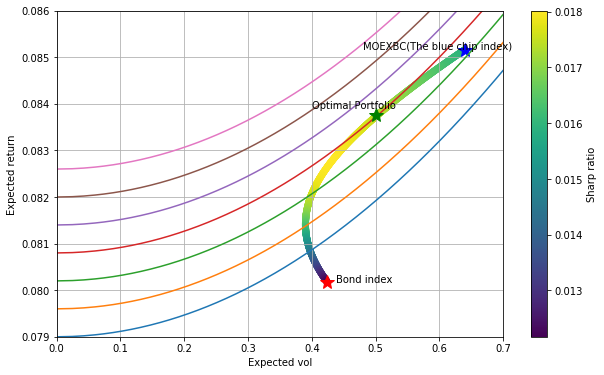

In [197]:
_=plt.figure(figsize = (10, 6))
_=plt.scatter(block['Volatility'], block['Mu'], c = block['Sharp_ratio'], marker = 'o')
_=plt.plot(block.iloc[0, 4], block.iloc[0, 3],'b*', markersize=15)
_=plt.plot(block.iloc[len(block.index) - 1, 4], block.iloc[len(block.index) - 1, 3],'r*', markersize=15)
for i in z:
    _=plt.plot(a, [j + i for j in b])
_=plt.grid(True)
_=plt.plot(0.5, 0.08375,'g*', markersize=15)
_=plt.annotate('Optimal Portfolio', xy=(0.4, 0.0839))
_=plt.annotate('MOEXBC(The blue chip index)', xy=(block.iloc[0, 4] * .75, block.iloc[0, 3]))
_=plt.annotate('Bond index', xy=(block.iloc[len(block.index) - 1, 4] * 1.03, block.iloc[len(block.index) - 1, 3]))
_=plt.xlabel('Expected vol')
_=plt.ylabel('Expected return')
_=plt.colorbar(label='Sharp ratio')
_=plt.ylim(.079, .086)
_=plt.xlim(0, .7)

In [217]:
c = [i for i in list(work[4])]
d = [i for i in list(np.linspace(.076,.086, 1000))]

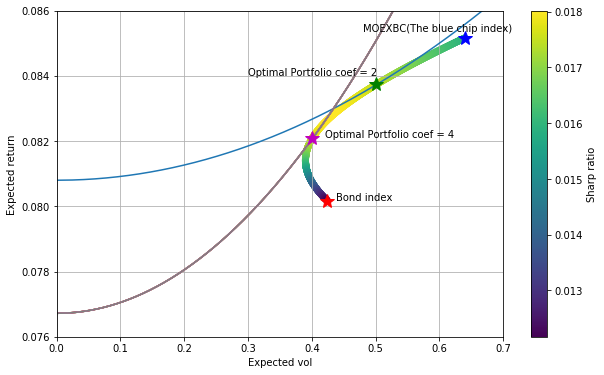

In [244]:
_=plt.figure(figsize = (10, 6))
_=plt.scatter(block['Volatility'], block['Mu'], c = block['Sharp_ratio'], marker = 'o')
_=plt.plot(block.iloc[0, 4], block.iloc[0, 3],'b*', markersize=15)
_=plt.plot(block.iloc[len(block.index) - 1, 4], block.iloc[len(block.index) - 1, 3],'r*', markersize=15)
_=plt.plot(a, [j + .0018 for j in b])
for i in z:
    _=plt.plot(c, [j + .00072 for j in d])
_=plt.grid(True)
_=plt.plot(0.5, 0.08375,'g*', markersize = 15)
_=plt.plot(0.4, 0.0821,'m*', markersize = 15)
_=plt.annotate('Optimal Portfolio coef = 2', xy=(0.3, 0.084))
_=plt.annotate('Optimal Portfolio coef = 4', xy=(0.42, 0.0821))
_=plt.annotate('MOEXBC(The blue chip index)', xy=(block.iloc[0, 4] * .75, block.iloc[0, 3] + 0.0002))
_=plt.annotate('Bond index', xy=(block.iloc[len(block.index) - 1, 4] * 1.03, block.iloc[len(block.index) - 1, 3]))
_=plt.xlabel('Expected vol')
_=plt.ylabel('Expected return')
_=plt.colorbar(label='Sharp ratio')
_=plt.ylim(.076, .086)
_=plt.xlim(0, .7)